## Jigsaw TPU:XLM-Roberta
- 주요 초점 영역은  `독성을 식별할 수 있는 머신러닝 모델`
- 독성은 무례하거나 무례한 것으로 정의되거나 
- 누군가 토론을 떠날 가능성이 있는 것으로 정의된다.
- 만약 이러한 독성 기여가 확인된다면, 우리는 더 안전하고, 더 협력적인 인터넷을 가질 수 있을 것이다.
- 올해는 새로운 TPU 지원을 활용, 
- `영어 전용 훈련 데이터`로 `다국어 모델 구축`에 도전한다.

In [ ]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

## Functions

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    #chunk_size = 256 .. 큰 덩어리 사이즈
    # tokenizer의 라이브러리 사용
    # 각각 문장의 시작 부분이나 끝 부분 또는 단어 시퀀스 중 
    # maxlen(=512)보다 큰 시퀀스에서 값을 제거한다.
    tokenizer.enable_truncation(max_length=maxlen)
    # padding: 'pre' or 'post', pad either before or after each sequence.
    # max_sentences: The max sentence length to use.
    # 문장 길이는 최대 512로
    tokenizer.enable_padding(max_length=maxlen)

    all_ids = []
    # texts의 처음부터 끝까지 chunk_size(=256)씩 건너띄면서
    for i in tqdm(range(0, len(texts), chunk_size)):
        # text_chunk는 해당 인덱스에서 256개문자의 data
        # tolist() = data를 list형태로
        text_chunk = texts[i:i+chunk_size].tolist()
        # tokenize multiple sentences at once;
        # 한번에 여러문장들을 토큰화
        #....백만건에 문장을 10초로
        encs = tokenizer.encode_batch(text_chunk)
        # encs의 문자들이 all_ids에 덮어진다
        all_ids.extend([enc.ids for enc in encs])
        
    # 배열 생성함수
    # 순서가 있는 객체(주로 리스트)를 넘겨받아 데이터가 들어있는 새로운 NumPy 배열 생성
    return np.array(all_ids)

In [ ]:
# 인코드 작업은 단어를 벡터(Vector)로 변환해 단어의 의미를 캡슐화하는 것으로, 
# 비슷한 단어의 숫자가 더 가깝다.
def regular_encode(texts, tokenizer, maxlen=512):
    # encode the word to vector of integer
    # 단어를 정수의 벡터로 인코딩
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        # masking 처리가 된 토큰들에게 attention점수를 준 값 반환 X
        return_attention_masks=False, 
        # type_ids = 형식 식별자 목록
        # string_id 색인 기준으로 정렬해야하며 중복항복이 포함되지 않는 목록
        return_token_type_ids=False,
        # First sentence will have some PADDED tokens to match second sequence length
        # 첫 번째 문장은 두 번째 시퀀스 길이와 일치하는 PADED 토큰이 (TRUE) 있을 것이다.
        pad_to_max_length=True,
        max_length=maxlen   // 512
    )
    # 배열 생성함수
    # 순서가 있는 객체(주로 리스트)를 넘겨받아 데이터가 들어있는 새로운 NumPy 배열 생성
    return np.array(enc_di['input_ids'])

## Bert 언어모델
- Bi-directional Encoder Representations from Transformers

`간단한 설명`
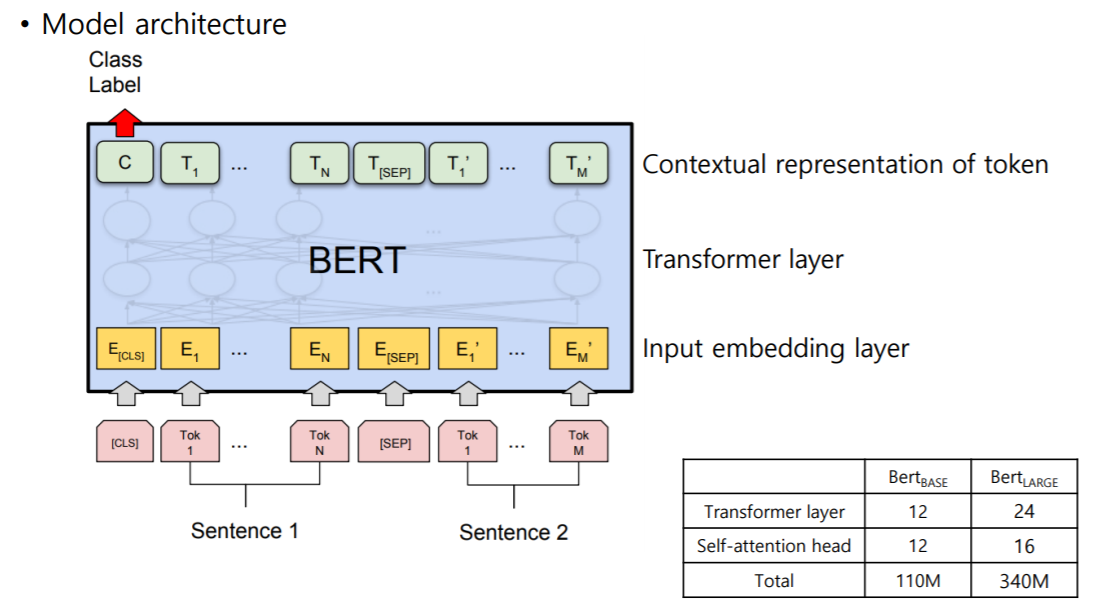

- input은 sectence 문장 두개로 입력
- sentence는 token 단위로 imbedded
- imbedded된 것은 transformer layer 12개를 거친 후에 본인을 표현

![image.png](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)
- cls

In [ ]:
def build_model(transformer, max_len=512):
    #Input: for define input layer 
    #shape is vector with 512-dimensional vectors
    #512차원 벡터를 가진 텐서 반환
    # dtype(data type) : tf.int32 (int32 정수)
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") # 입력 layer 정의
    sequence_output = transformer(input_word_ids)[0]
     
    # to get the vector
    # cls
    # 모든 sentence의 첫번째 token은 언제나 cls를 갖는다
    # 문장의 시작을 알리는 토큰
    # transformer의 encoding을 마치면 cls토큰은 
    # 나머지 이후 토큰들의 의미들을 응축하게 된다
    cls_token = sequence_output[:, 0, :]
    
    # define output layer
    # Dense layer : 모든 입력 뉴런과 출력 뉴런을 연결하는 전 결합층
    # activation = 'sigmond'함수는 활성화 함수로
    # 입력되는 값을 0 과 1 사이의 값으로 출력 됩니다.
   
    out = Dense(1, activation='sigmoid')(cls_token)
    # cls token과 레이어가 매끄럽게 학습될 수 있도록 한다
    # initiate the model with inputs and outputs
    
    model = Model(inputs=input_word_ids, outputs=out)
    # model.compile()에서 Adam optimizer 사용
    # lr: 0보다 크거나 같은 float 값. 학습률.
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# TPU Configs

## Run Bert Model on TPU

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
MODEL = 'jplu/tf-xlm-roberta-large'

In [ ]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

In [ ]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)